In [1]:
import os
import glob
import numpy as np
import scipy.signal
import scipy.io.wavfile
import scipy.interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Inputs
ref_path = r".\data\input\ref_samples.wav"
segment_paths = glob.glob(os.path.join(".\data\input\segments", "validation*.wav"))

In [3]:
# Load data
dataset = dict()
dataset['ref'] = dict()
dataset['ref']['sample_rate'], dataset['ref']['amps'] = scipy.io.wavfile.read(ref_path)  # load ref data
print(f"ref sample rate: {dataset['ref']['sample_rate'] / 1000} KHz")

for p in tqdm(segment_paths):  # load segments data
    name = os.path.basename(p).split('.wav')[0]
    dataset[name] = dict()
    dataset[name]['sample_rate'], dataset[name]['amps'] = scipy.io.wavfile.read(p)

ref sample rate: 16.0 KHz


In [78]:
class AudioSegmentFinder():
    def __init__(self, ref_signal, ref_sample_rate):
        self.ref_signal = ref_signal
        self.ref_sample_rate = ref_sample_rate   
    
    @staticmethod
    def find_max_correlation_time(ref_signal, seg_signal):
        ref_signal = ref_signal.copy() / np.max(ref_signal)
        seg_signal = seg_signal.copy() / np.max(seg_signal)
            
        res = scipy.signal.correlate(ref_signal, seg_signal, mode='valid')  # convolve ref and segment arrays (flip the mask array)
        max_index = np.argmax(res)  # index of max correlation point
        max_correlation_sample = max_index
        return max_correlation_sample, res
    
    @staticmethod
    def slice_estimated_segment(ref_signal, seg_signal, _x):
        shifted_x = list(range(_x, len(seg_signal) + _x))
        ref_segment_estimate = ref_signal[shifted_x].copy().astype(float)
        return ref_segment_estimate, shifted_x
    
    @staticmethod
    def lowpass_filter(data, fs, order=5):
        normal_cutoff = 0.5
        b, a = scipy.signal.butter(order, normal_cutoff)
        y = scipy.signal.lfilter(b, a, data)
        return y

    def run(self, seg_signal, seg_sample_rate):
        ref_signal = self.ref_signal.copy()
        sample_rate_ratio = int(self.ref_sample_rate / seg_sample_rate)
        
        # downsample ref signal if necessary
        ref_signal = ref_signal[::int(sample_rate_ratio)]  # if sample rate is identical, this line will have no effect
        
        # remvoe DC offsets
        ref_signal -= np.mean(ref_signal)     
        seg_signal -= np.mean(seg_signal)  
        
        # low pass filter
        ref_signal = self.lowpass_filter(ref_signal, self.ref_sample_rate)
        seg_signal = self.lowpass_filter(seg_signal, seg_sample_rate)
        
        max_correlation_sample, correlation = self.find_max_correlation_time(ref_signal, seg_signal)
        ref_segment_estimate, shifted_x = self.slice_estimated_segment(ref_signal, seg_signal, max_correlation_sample)
        return ref_segment_estimate, shifted_x, max_correlation_sample, correlation

ref 0.0
validation_seg_0_16000hz 60.9976875
validation_seg_0_16000hz_eq+chorus 60.9529375
validation_seg_0_16000hz_eq+reverb+brown_noise 60.998375
validation_seg_0_16000hz_eq+reverb 60.998375
validation_seg_0_16000hz_eq 60.9961875
validation_seg_0_8000hz_eq 60.99625
validation_seg_1_16000hz 21.6085
validation_seg_1_16000hz_eq+chorus 21.56125
validation_seg_1_16000hz_eq+reverb+brown_noise 21.6091875
validation_seg_1_16000hz_eq+reverb 21.6091875
validation_seg_1_16000hz_eq 21.6091875
validation_seg_1_8000hz_eq 21.609125


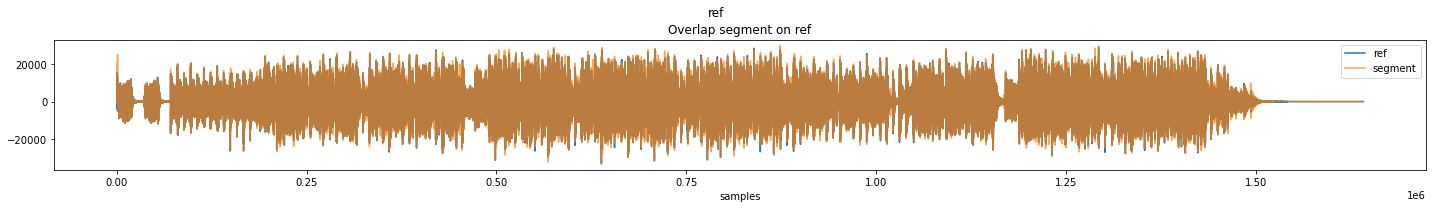

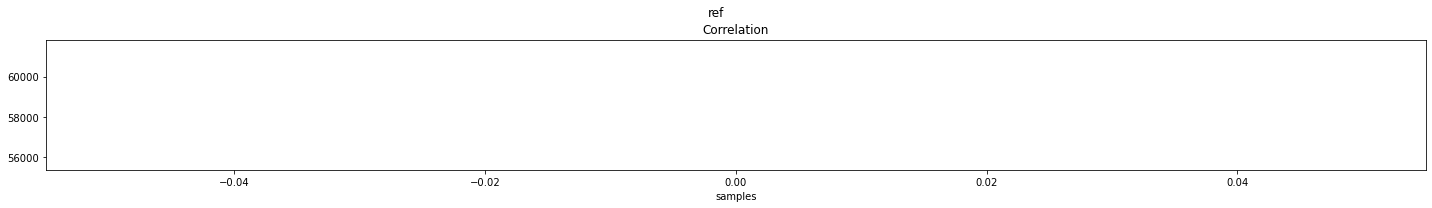

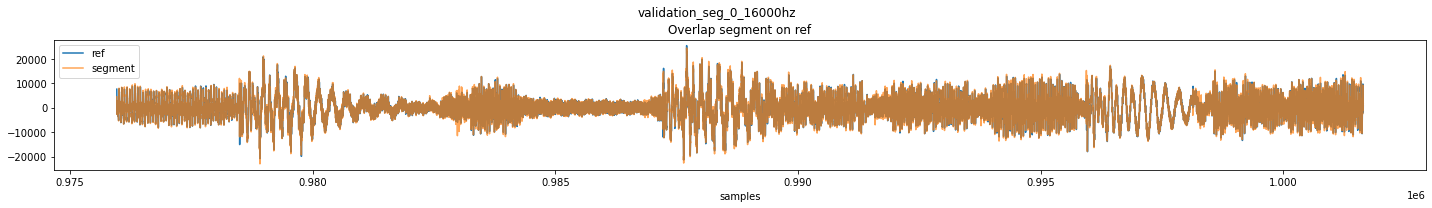

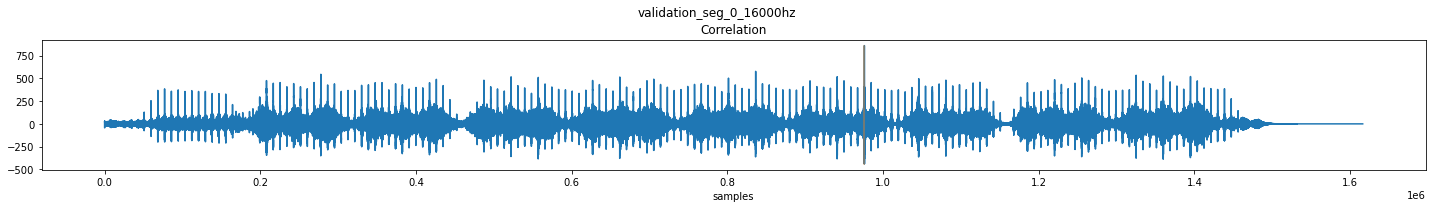

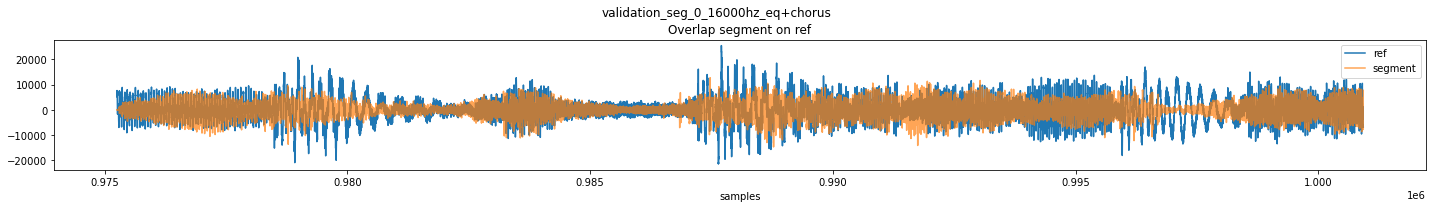

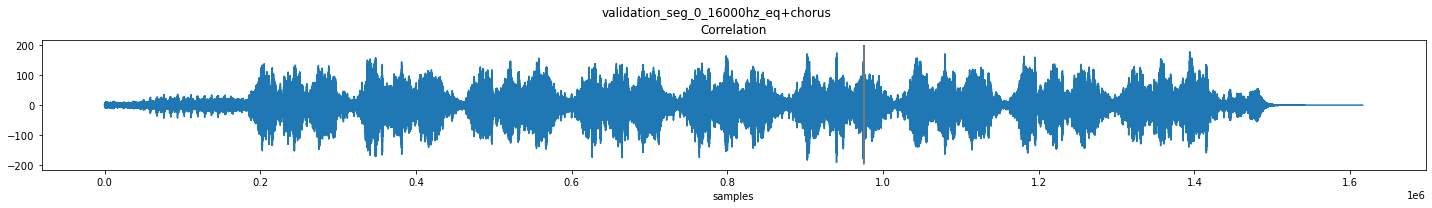

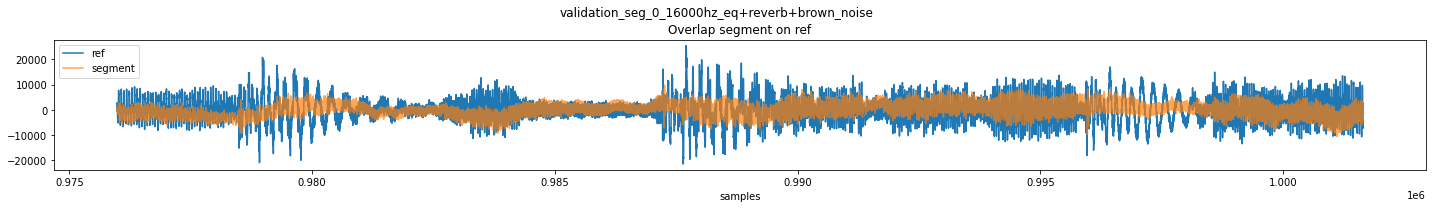

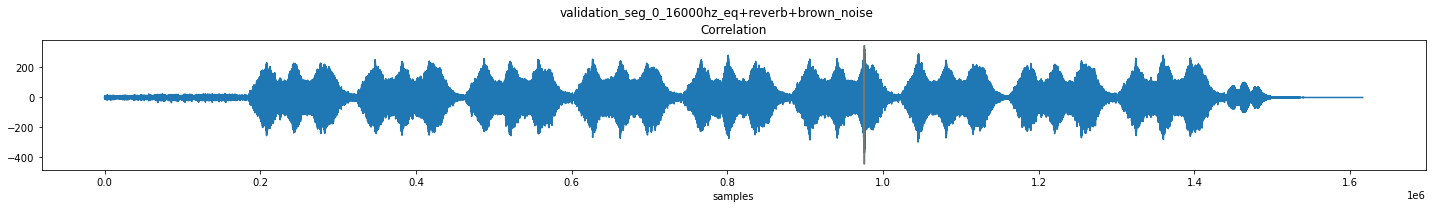

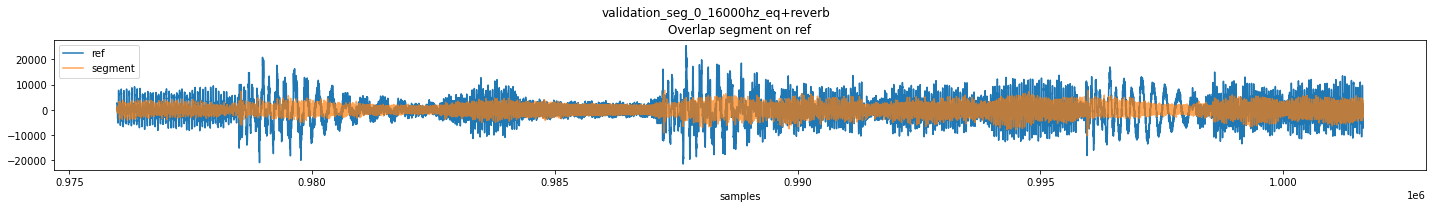

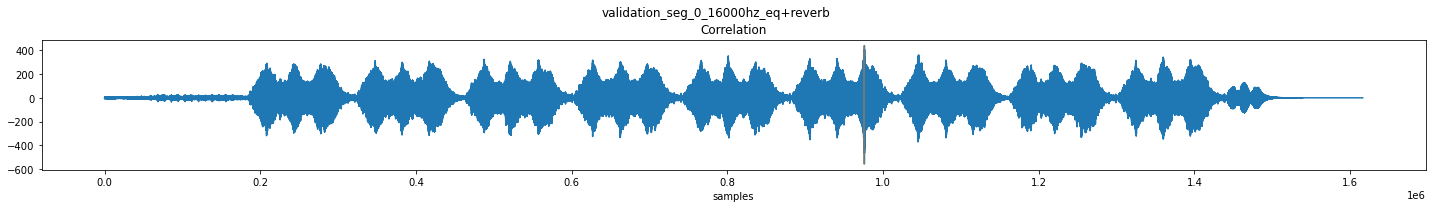

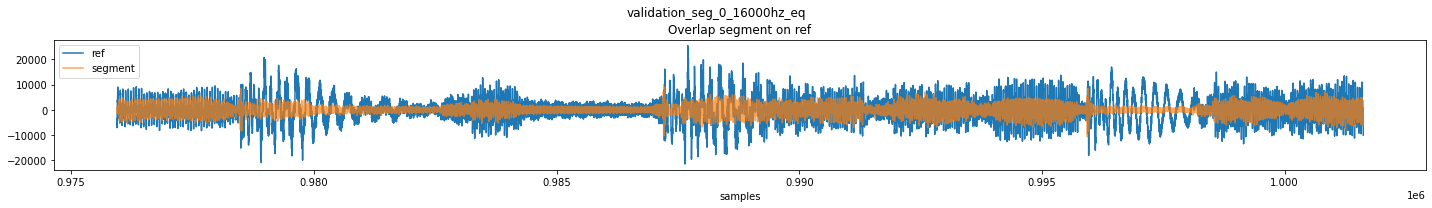

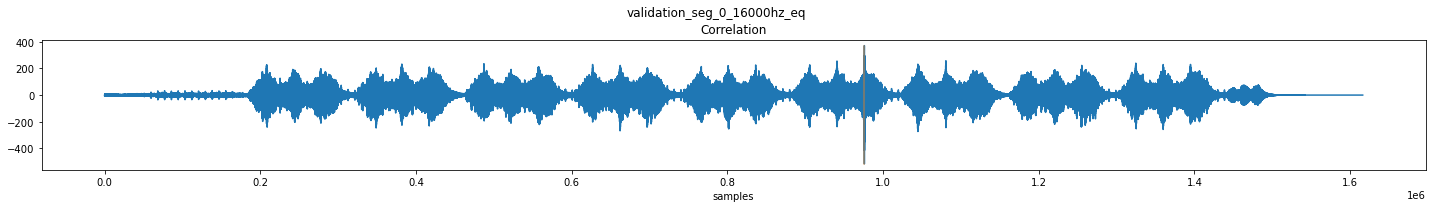

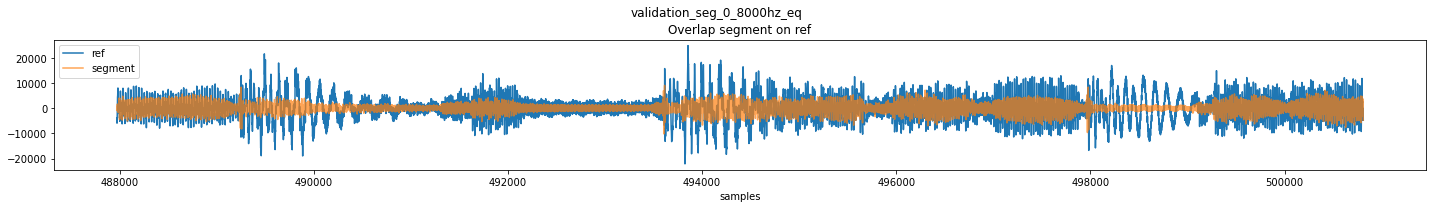

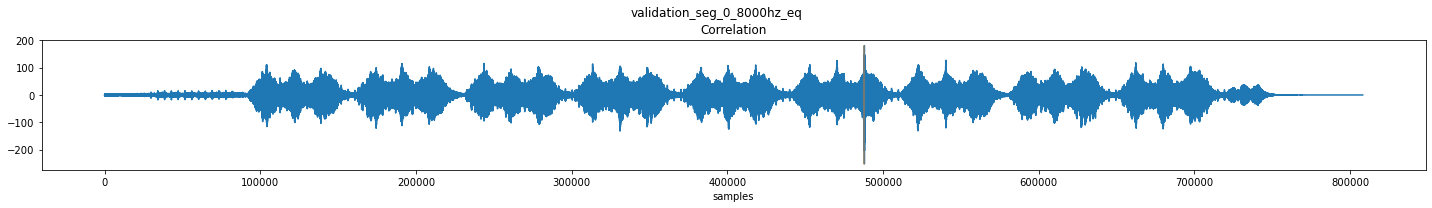

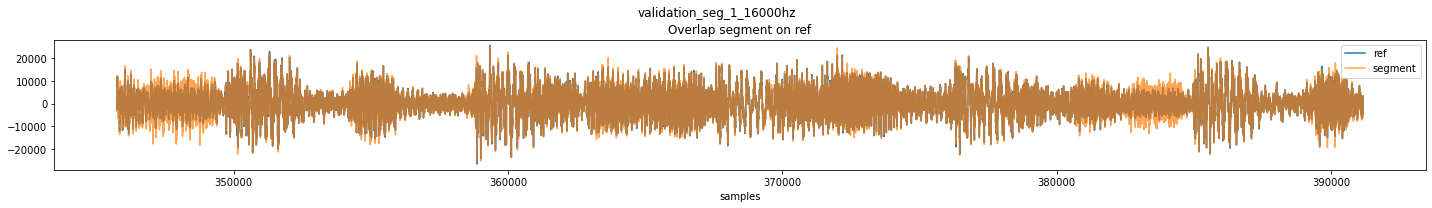

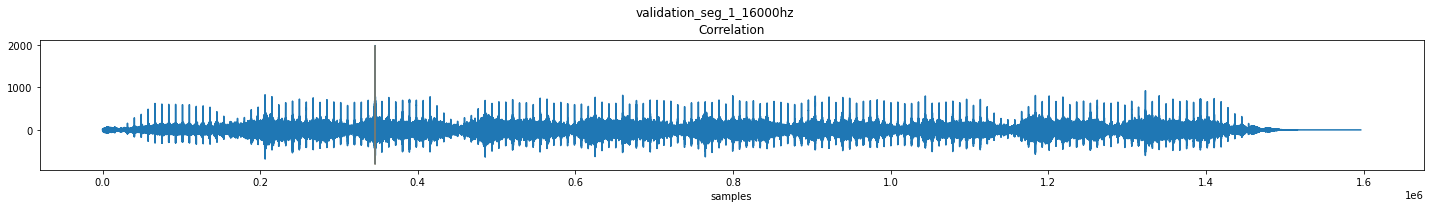

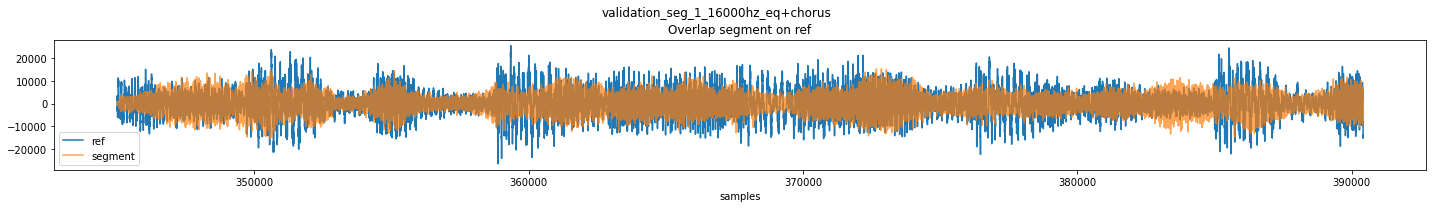

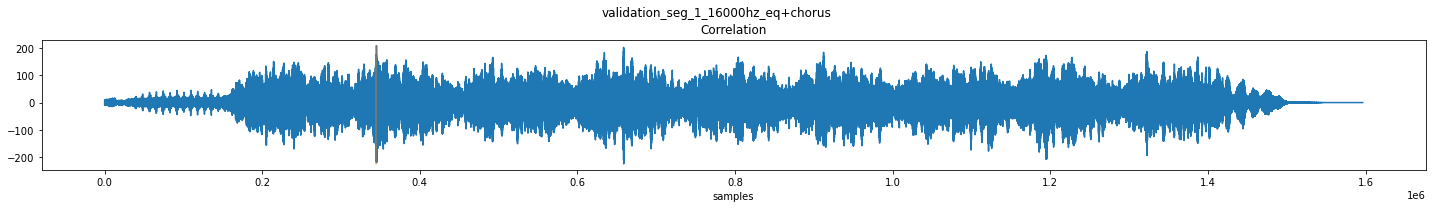

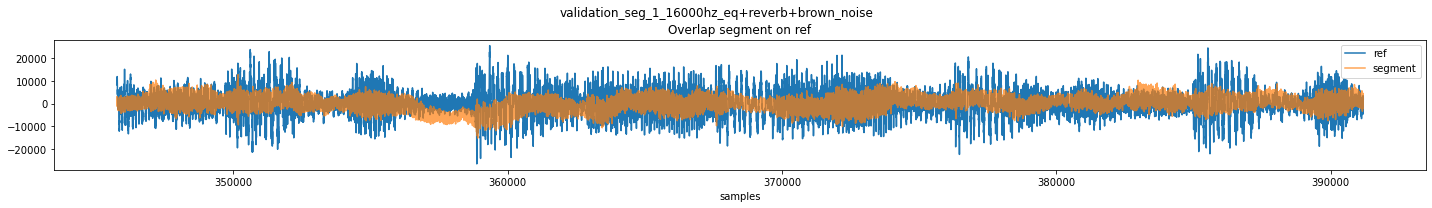

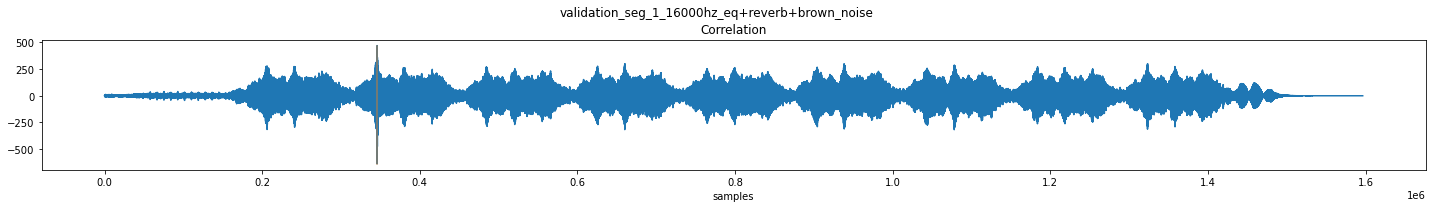

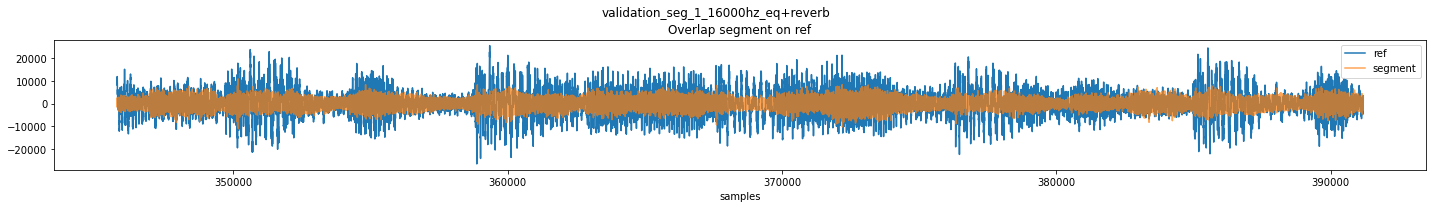

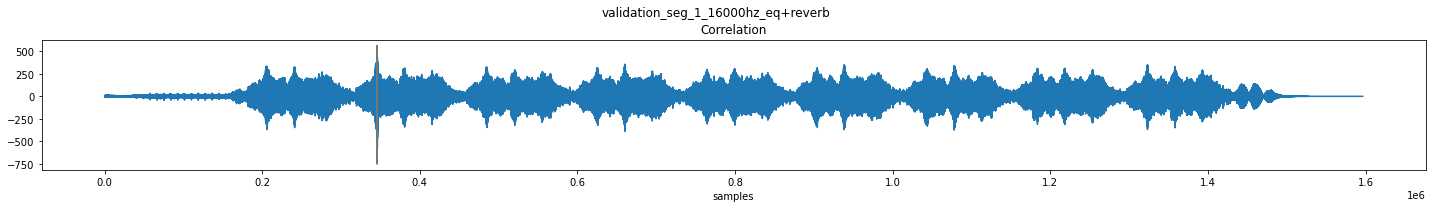

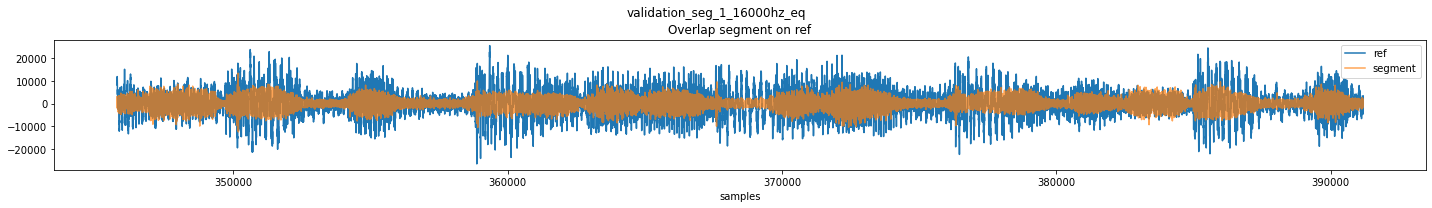

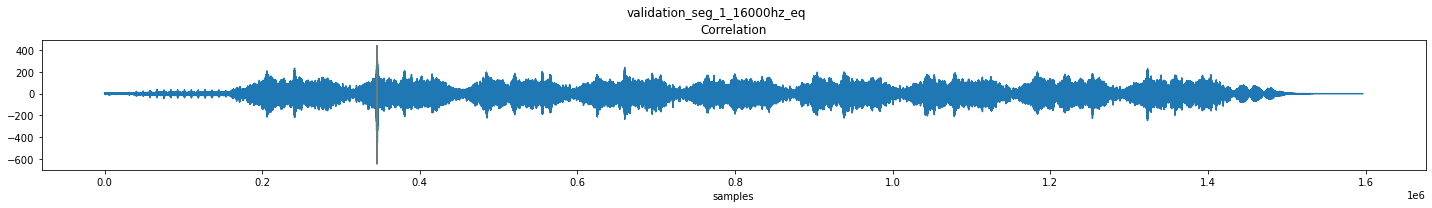

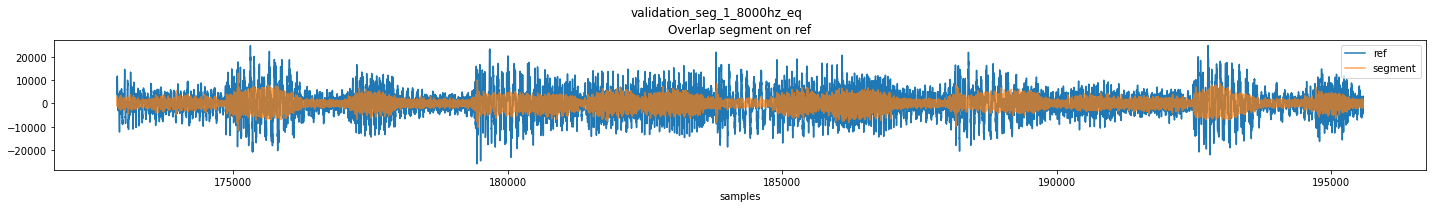

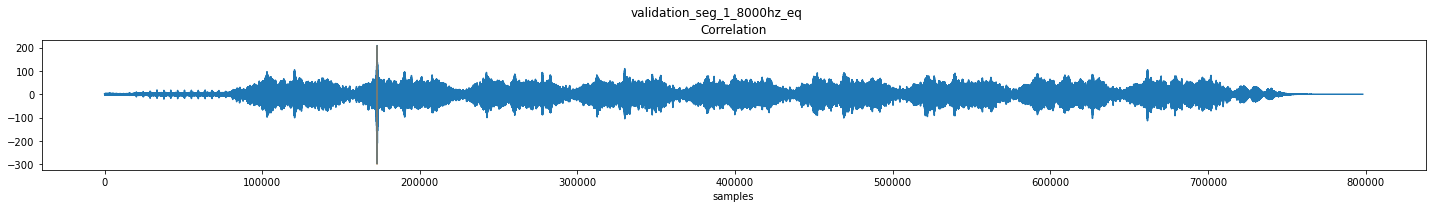

In [79]:
# cross correlate
audio_matcher = AudioSegmentFinder(ref_signal=dataset['ref']['amps'].copy().astype(float),
                                   ref_sample_rate=dataset['ref']['sample_rate'])
    
for name in dataset:
    seg_signal, seg_sample_rate = dataset[name]['amps'].copy().astype(float), dataset[name]['sample_rate']
    ref_segment_estimate, shifted_x, max_correlation_sample, correlation = audio_matcher.run(seg_signal, seg_sample_rate)
    dataset[name]['offset_correction'] = max_correlation_sample * dataset['ref']['sample_rate'] / dataset[name]['sample_rate']
    
    # PLOTS
    # plot ref and segment time series signals
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(20,3)) 
    fig.suptitle(name)
    axs.plot(shifted_x, ref_segment_estimate, label='ref')
    axs.plot(shifted_x, seg_signal, label=f'segment', alpha=0.7)
    axs.set_title('Overlap segment on ref')
    axs.set_xlabel('samples')
    axs.legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # plot ref and segment time series signals
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(20,3)) 
    fig.suptitle(name)
    axs.plot(correlation)
    axs.plot([max_correlation_sample,max_correlation_sample], [np.min(correlation), np.max(correlation)], alpha=0.5)
    axs.set_title('Correlation')
    axs.set_xlabel('samples')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save ref signal segment for validation
    scipy.io.wavfile.write(os.path.join('.', 'data', 'validation', f'{name}_from_ref.wav'), dataset['ref']['sample_rate'], ref_segment_estimate.astype('int16'))
    
    # Print timestamp 
    print(name, dataset[name]['offset_correction'] / dataset['ref']['sample_rate'])